# Import and Initialization

In [1]:
%load_ext autoreload
%autoreload 2

import tensorflow as tf

# standard library imports
from __future__ import absolute_import, division, print_function

# standard numerical library imports
import numpy as np

# energyflow imports
import energyflow as ef
from energyflow.archs import PFN
from energyflow.datasets import qg_jets
from energyflow.utils import data_split, remap_pids, to_categorical

from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt


import pandas
import h5py
import pickle

import datetime

In [2]:
# configs
train, val, test = 0.6, 0.3, 0.1
Phi_sizes, F_sizes = (256, 256, 256), (256, 256, 256)
num_epoch = 500
batch_size = 1000

# Load and Process Data

In [3]:
b_signal_file = "/global/home/users/yifengh3/VAE/data/B_signal.h5"
background_file = "/global/home/users/yifengh3/VAE/data/B_background.h5"
b_signal_data = pandas.read_hdf(b_signal_file)
background_data = pandas.read_hdf(background_file)

In [4]:
print("backgroubackground_datand data shape: {}".format(background_data.shape))
print("B signal data shape: {}".format(b_signal_data.shape))

backgroubackground_datand data shape: (2000000, 150)
B signal data shape: (50000, 150)


In [5]:
# assign labels to signal and background data, 0 for background,  1 for b-signal
# (updated since we might get multiple signals) 
labeled_background_data = np.append(background_data,np.zeros((background_data.shape[0],1)),axis=1)
labeled_b_signal_data = np.append(b_signal_data,np.ones((b_signal_data.shape[0],1)),axis=1)

In [6]:
# mix two data array into one signal array
data = np.concatenate((labeled_b_signal_data,labeled_background_data))

#and shuffle the data
np.random.shuffle(data)

In [7]:
X = data[:,:-1]
y = data[:,-1]

In [8]:
print("shape of X: {}".format(X.shape))
print("shape of Y: {}".format(y.shape))

shape of X: (2050000, 150)
shape of Y: (2050000,)


In [9]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
total = b_signal_data.shape[0] + background_data.shape[0]
weight_for_0 = (1 / background_data.shape[0]) * (total / 2.0)
weight_for_1 = (1 / b_signal_data.shape[0]) * (total / 2.0)


class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for background: {:.2f}'.format(weight_for_0))
print('Weight for signal: {:.2f}'.format(weight_for_1))

Weight for background: 0.51
Weight for signal: 20.50


In [10]:
# To categorical as stipulated in example
Y = to_categorical(y, num_classes=2)

# Reshape X to shape (number of jets, 50, 3)
X = X.reshape(-1,50,3)

In [11]:
# normalizing jets
# copied from example
import tqdm
for x in tqdm.tqdm(X):
    # now add the status bar :)
    mask = x[:,0] > 0
    yphi_avg = np.average(x[mask,1:3], weights=x[mask,0], axis=0)
    x[mask,1:3] -= yphi_avg
    x[mask,0] /= x[:,0].sum()

100%|██████████| 2050000/2050000 [02:01<00:00, 16867.69it/s]


In [12]:
print('Finished preprocessing')
print("shape of X: {}".format(X.shape))
print("shape of Y: {}".format(y.shape))

Finished preprocessing
shape of X: (2050000, 50, 3)
shape of Y: (2050000,)


In [13]:
# do train/val/test split 
(X_train, X_val, X_test,
 Y_train, Y_val, Y_test) = data_split(X, Y, val=val, test=test)

# Build and Train the Model

In [14]:
print('Model summary:')

# build architecture
pfn = PFN(input_dim=X.shape[-1], Phi_sizes=Phi_sizes, F_sizes=F_sizes)

Model summary:
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, 3)]    0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 256)    1024        input[0][0]                      
__________________________________________________________________________________________________
activation (Activation)         (None, None, 256)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 256)    65792       activation[0][0]                 
_______________________________________________________________________________

In [15]:
# now train the model

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.1**(1/5), patience=5, min_lr=1e-5,
                                                verbose=1)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=40, 
                                              verbose=1)

callbacks = [reduce_lr,early_stop]

hist1 = pfn.fit(X_train, Y_train,
        epochs=num_epoch,
        batch_size=batch_size,
        validation_data=(X_val, Y_val),
        class_weight=class_weight,
        callbacks=callbacks,
        verbose=1)

Epoch 1/500
1230/1230 [==============================] - 12s 10ms/step - loss: 5.0950 - acc: 0.5086 - val_loss: 0.8024 - val_acc: 0.1078
Epoch 2/500
1230/1230 [==============================] - 11s 9ms/step - loss: 0.7059 - acc: 0.5183 - val_loss: 0.6237 - val_acc: 0.8705
Epoch 3/500
1230/1230 [==============================] - 11s 9ms/step - loss: 0.6980 - acc: 0.5428 - val_loss: 0.7286 - val_acc: 0.0823
Epoch 4/500
1230/1230 [==============================] - 11s 9ms/step - loss: 0.6981 - acc: 0.4985 - val_loss: 0.7082 - val_acc: 0.2930
Epoch 5/500
1230/1230 [==============================] - 11s 9ms/step - loss: 0.6924 - acc: 0.5643 - val_loss: 0.7414 - val_acc: 0.0517
Epoch 6/500
1230/1230 [==============================] - 11s 9ms/step - loss: 0.6934 - acc: 0.5707 - val_loss: 0.6626 - val_acc: 0.9589
Epoch 7/500
1230/1230 [==============================] - 11s 9ms/step - loss: 0.6886 - acc: 0.7879 - val_loss: 0.6981 - val_acc: 0.0249

Epoch 00007: ReduceLROnPlateau reducing learni

1230/1230 [==============================] - 11s 9ms/step - loss: 0.6388 - acc: 0.7067 - val_loss: 0.6248 - val_acc: 0.7220

Epoch 00055: ReduceLROnPlateau reducing learning rate to 1.0000000608891671e-05.
Epoch 56/500
1230/1230 [==============================] - 11s 9ms/step - loss: 0.6355 - acc: 0.7137 - val_loss: 0.6351 - val_acc: 0.7017
Epoch 57/500
1230/1230 [==============================] - 11s 9ms/step - loss: 0.6399 - acc: 0.7015 - val_loss: 0.6273 - val_acc: 0.7155
Epoch 58/500
1230/1230 [==============================] - 11s 9ms/step - loss: 0.6404 - acc: 0.7014 - val_loss: 0.6242 - val_acc: 0.7151
Epoch 59/500
1230/1230 [==============================] - 11s 9ms/step - loss: 0.6384 - acc: 0.7048 - val_loss: 0.6325 - val_acc: 0.7031
Epoch 60/500
1230/1230 [==============================] - 11s 9ms/step - loss: 0.6373 - acc: 0.7060 - val_loss: 0.6393 - val_acc: 0.6851

Epoch 00060: ReduceLROnPlateau reducing learning rate to 1e-05.
Epoch 61/500
1230/1230 [====================

# Analyze the Model

In [16]:
# get predictions on test data
preds = pfn.predict(X_test, batch_size=10000)

# get ROC curve
pfn_fp, pfn_tp, threshs = roc_curve(Y_test[:,1], preds[:,1])

# get area under the ROC curve
auc = roc_auc_score(Y_test[:,1], preds[:,1])
print()
print('PFN AUC:', auc)
print()


PFN AUC: 0.664538584878627



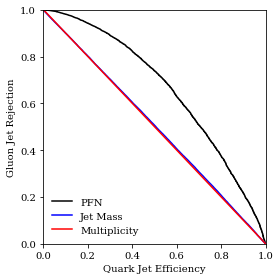

In [17]:
# get multiplicity and mass for comparison
masses = np.asarray([ef.ms_from_p4s(ef.p4s_from_ptyphims(x).sum(axis=0)) for x in X])
mults = np.asarray([np.count_nonzero(x[:,0]) for x in X])
mass_fp, mass_tp, threshs = roc_curve(Y[:,1], -masses)
mult_fp, mult_tp, threshs = roc_curve(Y[:,1], -mults)

# some nicer plot settings 
plt.rcParams['figure.figsize'] = (4,4)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.autolayout'] = True

# plot the ROC curves
plt.plot(pfn_tp, 1-pfn_fp, '-', color='black', label='PFN')
plt.plot(mass_tp, 1-mass_fp, '-', color='blue', label='Jet Mass')
plt.plot(mult_tp, 1-mult_fp, '-', color='red', label='Multiplicity')

# axes labels
plt.xlabel('Quark Jet Efficiency')
plt.ylabel('Gluon Jet Rejection')

# axes limits
plt.xlim(0, 1)
plt.ylim(0, 1)

# make legend and show plot
plt.legend(loc='lower left', frameon=False)
plt.show()


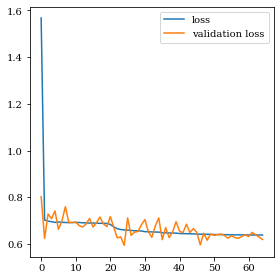

In [18]:
plt.plot(hist1.history["loss"],label="loss")
plt.plot(hist1.history["val_loss"],label="validation loss")
plt.legend()
plt.show()

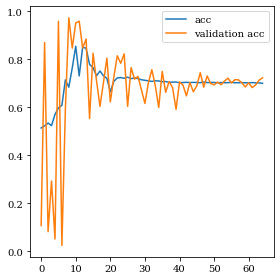

In [21]:
plt.plot(hist1.history["acc"],label="acc")
plt.plot(hist1.history["val_acc"],label="validation acc")
plt.legend()
plt.show()